# Doc2Vec
- Word2Vec의 확장판 모델 
- 기본적인 매개변수, 속성, 메서드는 Word2Vec과 같다. 
- 추가적인 부분이 생성 

- 매개변수 
    - dm 
        - 기본값이 1
        - 학습 알고리즘을 선택 
        - 1 : PV-DM 
        - 0 : PT-DBOW
    - dm_mean 
        - 기본값 : 0
        - PV-DM에서 문장 벡터의 계산 방식 
        - 0 : 벡터들의 합산 -> 범위가 커지는 경우가 발생 -> 노이즈로 인한 성능의 저하가 발생 할수 있음
        - 1 : 벡터들의 평균
    - dm_concat
        - 기본값 : 0
        - PV-DM에서 문서 벡터와 문장 벡터를 결합할것인가?
        - 결합을 하는 경우 차원이 급격하게 증가 
    - dbow_words
        - 기본값 : 0
        - PV-DBOW 사용 시 단어 벡터도 동시에 학습할것인가(Skip-gram 방식과 흡사)
- 속성 
    - model.wv 
        - 학습이 된 단어 벡터의 저장소
    - model.dv
        - 학습이 된 문장의 벡터의 저장소 
    - model.dv.index_to_key
        - 문서들의 ID값 리스트
- 메서드 
    - build_vocab()
        - 단어  / 문서 사전을 구성
    - train()
        - 사전이 구축이 된 뒤 직접 학습을 수행 

- build_vocab(), train() 메서드를 이용하여 수동으로 학습을 설정 
- 일반적으로는 Doc2Vec 객체를 생성할때 사전의 생성과 학습
- 증분 학습에서 사용이 되는 부분
    - 기존에 학습이 된 모델에 새로운 데이터셋을 추가 
    - 데이터의 양이 증가하면 성능이 오를수 있는 확률이 존재
    - 기존의 학습 시킨 데이터와 유사한 데이터를 증분학습하여 성능을 향상

In [1]:
# gensim 라이브러리 안에 Doc2Vec를 이용하여 임베딩 
from konlpy.tag import Komoran
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 
import re


In [2]:
# 샘플 데이터를 2개의 유형 문장들로 구성 
docs = [
    "나는 커피를 정말 좋아한다", 
    "오늘 아침에 에스프레소 두 잔을 마셨다", 
    '카페라떼가 제일 맛있다고 생각한다', 
    '나는 차를 더 자주 마신다', 
    '녹차를 마시면 기분이 편안해진다', 
    '홍차는 향이 깊고 고급스러운 느낌이다', 
    '카페에서 책을 읽는 시간이 너무 좋다', 
    '허브티도 몸에 좋은거 같다'
]

In [8]:
# 형태소 분석 Komoran을 이용하여 토큰화 
komoran = Komoran()

# 특정 품사만 사용 
allow_pos = [ 'NNP', 'NNG', 'VV', 'VA', 'MAG', 'XR' ]
# 불용어 
stop_word = ['하다', '되다', '이다', '것', '수', '거']

# 문자에서 불필요한 글자들을 제거 (정규화)
def nomalize(text):
    # 특수문자 제외 , 공백에 대한 처리 
    text = re.sub(r"[^가-힣0-9a-zA-Z\s\.]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 토큰화 함수를 정의 
def tokenize(text):
    # 문자의 정규화 함수를 호출 
    text = nomalize(text)

    tokens = []
    for word, pos in komoran.pos(text):
        if pos in allow_pos:
            # 길이를 체크하기 전에 동사, 형용사 에는 '다' 붙이기 활용
            if pos in ['VV', 'VA']:
                word += '다'
            if word not in stop_word and len(word) > 1:
                # allow_pos의 포함되어있고
                # stop_word에 포함되어있지 않으며
                # 단어의 길이가 1보다 큰 문자만 활용
                tokens.append(word)
    return tokens

In [9]:
tokenize_docs = [ tokenize(doc) for doc in docs ]
tokenize_docs

[['커피', '정말', '좋아하다'],
 ['오늘', '아침', '에스프레소', '마시다'],
 ['카페', '제일', '맛있다', '생각'],
 ['자주', '마시다'],
 ['녹차', '마시다', '기분', '편안'],
 ['홍차', '깊다', '고급', '느낌'],
 ['카페', '읽다', '시간', '너무', '좋다'],
 ['허브', '좋다', '같다']]

In [ ]:
# 문장 별로 ID 를 지정 
tagged = []
for idx, toks in enumerate(tokenize_docs):
    # TaggedDcoumnt를 이용하여 문장 당 ID 을 부여하고 tagged에 추가 
    tagged.append(
        TaggedDocument(words = toks, tags=[f"DOC_{idx}"])
    )
tagged

In [12]:
# tag을 추가한 문서를 이용해서 Doc2Vec 모델에 학습 데이터로 이용
model = Doc2Vec(
    documents= tagged, 
    vector_size= 120, 
    window= 5, 
    min_count = 1,   # 데이터의 개수가 작기 때문, 실제 3-5
    dm = 1,    # PV-DM 방식
    dm_mean = 1,    # 벡터들의 평균(범위를 크지 않게 잡아서 안정적)
    negative = 5,   # 잘못된 단어간의 배치를 사용하여 학습에 이용
    epochs= 50, 
    seed = 42
)

In [13]:
print("학습이 된 문장의 개수", len(model.dv))

학습이 된 문장의 개수 8


In [ ]:
# 문장 간의 유사도를 수치적으로 확인 
def print_similities(doc_id):
    # 수정1
    dic_vec = model.dv[f"DOC_{doc_id}"]

    # doc_id : 문서의 tag 이름
    # 각각의 문장들의 벡터 데이터를 리스트로 생성
    mat = np.vstack(
        [model.dv[f"DOC_{i}"] for i in range(len(docs))]
    )
    # 코사인 유사도 사용
    # 수정2
    sims = cosine_similarity( [dic_vec], mat )[0]

    order = sims.argsort()[::-1]

    # 수정 3
    print(f"기존의 문장 : {doc_id} -> {docs[doc_id]}" )
    for idx in order:
        print( f"   -> {idx} {docs[idx]}   |  cos = {sims[idx]}" )

print_similities(0)

기존의 문장 : 0 -> 나는 커피를 정말 좋아한다
   -> 0 나는 커피를 정말 좋아한다   |  cos = 1.0
   -> 7 허브티도 몸에 좋은거 같다   |  cos = 0.1954648792743683
   -> 1 오늘 아침에 에스프레소 두 잔을 마셨다   |  cos = 0.13140203058719635
   -> 3 나는 차를 더 자주 마신다   |  cos = 0.06367944180965424
   -> 6 카페에서 책을 읽는 시간이 너무 좋다   |  cos = 0.01677805185317993
   -> 4 녹차를 마시면 기분이 편안해진다   |  cos = 0.007417656481266022
   -> 2 카페라떼가 제일 맛있다고 생각한다   |  cos = -0.06176169961690903
   -> 5 홍차는 향이 깊고 고급스러운 느낌이다   |  cos = -0.11510717123746872


In [18]:
# 차원 축소 기법을 이용해서 그래프 시각화 
# 각 문장들 간에 거리를 확인 
from sklearn.manifold import TSNE

In [21]:
# 차원 축소를 하기 위해서는 -> 고차원의 데이터 필요
X = np.vstack(
    [model.dv[f"DOC_{idx}"] for idx in range(len(docs))]
)
X.shape

(8, 120)

In [22]:
# t-SNE를 이용하여 2D 변경 
tsne = TSNE(
    n_components=2, 
    perplexity=5, 
    max_iter=2000, 
    random_state=42
)

In [23]:
# 차원 축소 모델에 학습을 시키고 데이터를 변형한다. 
X_2d = tsne.fit_transform(X)

In [24]:
X_2d.shape

(8, 2)

In [25]:
import matplotlib.pyplot as plt

In [31]:
# 그래프는 산점도 그래프 
# 각각의 점에 주석 추가 -> 해당 위치의 문장의 데이터
# 문장들이 한글 -> 기본적인 matplot 폰트에서는 한글 지원X -> 폰트를 변경
# 각각의 os에 따라서 폰트 설정이 다름
import platform 

if platform.system() == 'Darwin':
    plt.rc('font', family= 'AppleGothic')
else:
    plt.rc('font', family='Malgun Gothic')
# 마이너스 부호 깨짐의 방지 
plt.rcParams['axes.unicode_minus'] = False

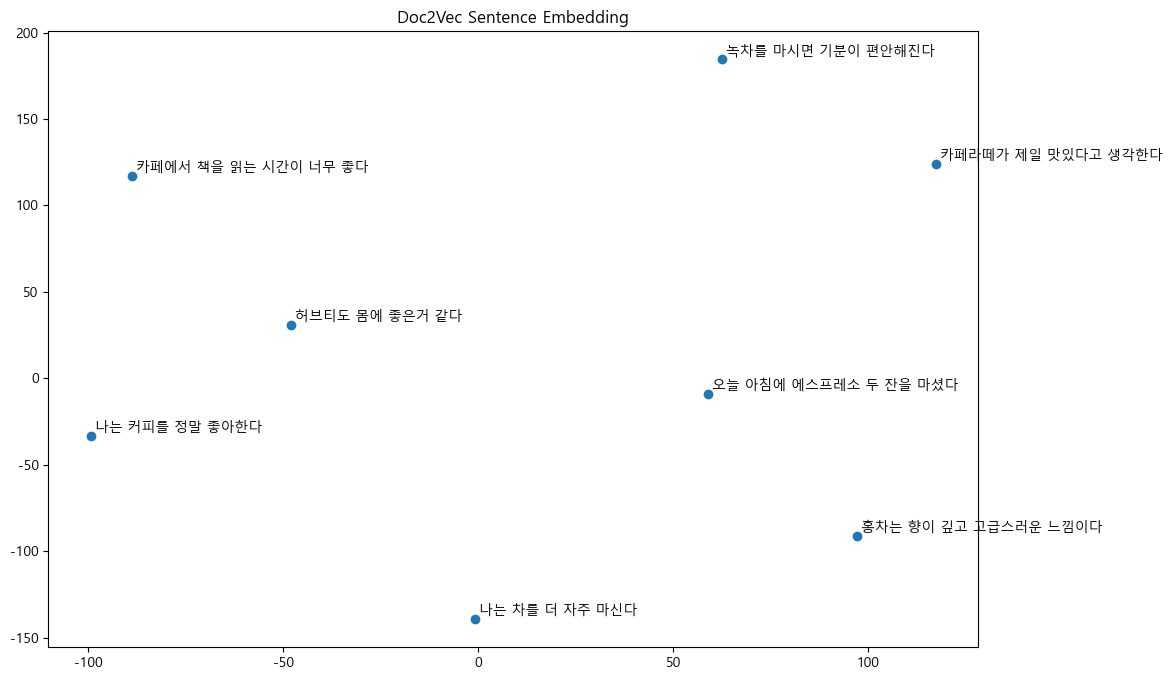

In [32]:
plt.figure(figsize=(12, 8))
# 산점도 그래프를 생성 -> X축 데이터, Y축 데이터 -> 
# X_2d의 첫번째 열과 두번째 열의 데이터
plt.scatter(X_2d[:, 0], X_2d[:, 1])

# 각각의 점들에 문장 데이터를 주석으로 추가 
for idx, text in enumerate(docs):
    plt.annotate(
        text, 
        # 주석의 원 데이터의 위치 
        xy= (X_2d[idx, 0] , X_2d[idx, 1]), 
        # 주석의 위치
        xytext= (3, 3), 
        textcoords='offset points'  # 각각의 위치에 텍스트 대입
    )

plt.title('Doc2Vec Sentence Embedding')
plt.show()

In [34]:
# 문장 별 벡터의 값을 이용하여 기계 학습 
# 학습 데이터(독립 변수) -> 문장별 벡터 데이터 
# 타깃 데이터(종속 변수) -> 커피(1), 차(0)으로 데이터를 생성
Y = np.array([1, 1, 1, 0, 0, 0, 1, 0])

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42
)
# 로즈스틱 회귀 모델 생성 
clf = LogisticRegression(max_iter=2000)

In [37]:
# 모델에 학습 
clf.fit(X_train, Y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,2000
,multi_class,'deprecated'


In [38]:
pred = clf.predict(X_test)
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.00      0.00      0.00         2

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



c:\Users\ekfla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ekfla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ekfla\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

#### Doc2Vec를 Komoran과 PyTorch를 이용하여 구현

In [40]:
import re, collections
import torch 
# nn : 파이토치의 모델
import torch.nn as nn
# 옵티마이저
import torch.optim as optim
# 모델에서 사용하기 편한 형태로 데이터의 유형을 변경
from torch.utils.data import Dataset, DataLoader
from konlpy.tag import Komoran

In [41]:
# 데이터셋 위의 데이터 그대로 사용
docs_raw = docs.copy()

In [ ]:
docs_raw

In [45]:
# 형태소 분석 객체 생성
komoran = Komoran()
# 품사 선택
allow_pos = ['NNP', 'NNG', 'VV', 'VA', 'MAG', 'XR']
# 불용어 처리 
stop_word = ['하다', '되다', '이다', '것', '수', '거']

# 문자의 간단한 정규화 함수 
def nomalize(text):
    text = re.sub(r"[^가-힣0-9a-zA-Z\s\.]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# 토큰화 함수 
def tokenize_komoran(text):
    # 텍스트 정규화 
    text = nomalize(text)
    tokens = []
    for word, pos in komoran.pos(text):
        if word not in stop_word and len(word) > 1 and\
              pos in allow_pos:
            tokens.append(word)
    return tokens

tokenized_docs = [tokenize_komoran(doc) for doc in docs_raw]
tokenized_docs


[['커피', '정말', '좋아하'],
 ['오늘', '아침', '에스프레소', '마시'],
 ['카페', '제일', '맛있', '생각'],
 ['자주', '마시'],
 ['녹차', '마시', '기분', '편안'],
 ['홍차', '고급', '느낌'],
 ['카페', '시간', '너무'],
 ['허브']]

In [47]:
# 단어 사전 생성 
# doc2vec을 생각하면 -> min_count(단어의 최소 등장 횟수)
min_count = 1
# 단어들의 출현 횟수를 dict의 형태로 생성 
freq = collections.Counter(
    word for doc in tokenized_docs for word in doc
)
freq

Counter({'마시': 3,
         '카페': 2,
         '커피': 1,
         '정말': 1,
         '좋아하': 1,
         '오늘': 1,
         '아침': 1,
         '에스프레소': 1,
         '제일': 1,
         '맛있': 1,
         '생각': 1,
         '자주': 1,
         '녹차': 1,
         '기분': 1,
         '편안': 1,
         '홍차': 1,
         '고급': 1,
         '느낌': 1,
         '시간': 1,
         '너무': 1,
         '허브': 1})

In [ ]:
# 단어 사전을 생성 -> min_count의 수보다 크거나 같은 경우 단어 사전에 등록
# 특수 토큰 -> "<PAD>" : 
# 패딩의 의미(단어의 개수가 달라서 단어별 벡터 비교하는 경우 
# 개수를 맞춰주기위한 토큰)
# "<UNK>"
    # 단어 사전에 없는 단어를 표기할때 사용 (OOV)
# 특수 토큰들을 포함시킨 단어 사전을 생성 
vocab = ['<PAD>', '<UNK>'] + [
    word for word, cnt in freq.items() if cnt >= min_count
]
vocab

In [ ]:
word_list = [] 
for word, cnt in freq.items():
    # print(word)
    # print(cnt)
    # break
    if cnt >= min_count:
        word_list.append(word)
# for key in freq:
#     print(key)
#     print(freq[key])
#     break

커피
1


In [ ]:
# 단어 사전에 단어들의 단어와 위치의 값을 이용한 dict 데이터를 생성
stoi = {
    word : idx for idx, word in enumerate(vocab)
}
stoi

In [53]:
# token화 된 데이터를 stoi의 데이터를 이용하여 인코딩 
def encode(words):
    result = [ stoi.get(word, stoi['<UNK>']) for word in words ]
    return result

encoded_docs = [ encode(doc) for doc in tokenized_docs ]

encoded_docs

[[2, 3, 4],
 [5, 6, 7, 8],
 [9, 10, 11, 12],
 [13, 8],
 [14, 8, 15, 16],
 [17, 18, 19],
 [9, 20, 21],
 [22]]

In [54]:
# 학습 샘플 생성 (PV-DM, window 기반)
    # ( 문장ID, [주변 단어 목록], 중심단어 )
def build_pvdm_samples(encoded_docs, window = 2):
    # encoded_doc : 인코딩 된 문장 데이터 
    samples = []
    for d_id, doc in enumerate(encoded_docs):
        # d_id : index 값 -> 문서의 고유 식별 번호 
        # doc : encoded_docs의 각각의 원소 
        if len(doc) < 2:
            # 중심 단어를 기준으로 주변 단어를 검색하는데 
            # 길이가 1이라면 주변 단어가 존재x 
            continue
        # 중심 단어에 따른 주변 단어들을 튜플의 형태로 저장 samples 추가
        for center in range(len(doc)):
            # center : 중심 단어의 위치 
            left = max( 0, center - window )
            right = min( len(doc), center + window + 1 )
            # ctx = [
            #     doc[i] for i in range(left, right) if center != i
            # ]
            # ctx : 주변 단어들의 목록
            ctx = []
            for i in range(left, right):
                if i != center:
                    # 중심 단어를 ctx에 포함시키지 않는다.
                    ctx.append(doc[i])
            # ( 문장ID, 주변 단어의 목록, 중심단어 ) 형태를 samples 추가 
            # ctx가 존재하는 경우에만 추가 
            if ctx:
                target = doc[center]
                samples.append(
                    ( d_id, ctx, target )
                )
    return samples
        

In [55]:
samples = build_pvdm_samples(encoded_docs)
samples

[(0, [3, 4], 2),
 (0, [2, 4], 3),
 (0, [2, 3], 4),
 (1, [6, 7], 5),
 (1, [5, 7, 8], 6),
 (1, [5, 6, 8], 7),
 (1, [6, 7], 8),
 (2, [10, 11], 9),
 (2, [9, 11, 12], 10),
 (2, [9, 10, 12], 11),
 (2, [10, 11], 12),
 (3, [8], 13),
 (3, [13], 8),
 (4, [8, 15], 14),
 (4, [14, 15, 16], 8),
 (4, [14, 8, 16], 15),
 (4, [8, 15], 16),
 (5, [18, 19], 17),
 (5, [17, 19], 18),
 (5, [17, 18], 19),
 (6, [20, 21], 9),
 (6, [9, 21], 20),
 (6, [9, 20], 21)]

In [67]:
# torch에 있는 linear 모델을 사용하기 위해 데이터의 형태를 알맞게 변경 
# Dataset, DataLoader
class PVDMDataset(Dataset):
    def __init__(self, samples):
        # class 내부에 독립적인 데이터를 생성
        self.samples = samples
    # DataLoader에서 사용이 되는 특수 함수를 생성 
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        d_id, ctx, target = self.samples[idx]
        return d_id, torch.tensor(ctx, dtype=torch.long), \
            torch.tensor(target, dtype=torch.long)

def collate_fn(batch):
    # 문맥에 따라 길이가 다 다르기 때문에 리스트를 그대로 전달
    # PAD 토큰은 문맥의 평균을 구해서 작업을 하기 때문에 필요x
    doc_ids, ctx_lists, targets = zip(*batch)
    # batch : [ [d_id, ctx, target], [d_id, ctx, target], .. ]
    return torch.tensor(doc_ids, dtype=torch.long), \
            torch.tensor(ctx_lists), \
            torch.tensor(targets)
# 데이터셋의 구성
dataset = PVDMDataset(samples)
# 데이터로더 생성 
loader = DataLoader( dataset, batch_size=64, shuffle=True, 
                    collate_fn=collate_fn )

In [62]:
def func_1(*a):
    print(a)
    return sum(a)
    
func_1(*[1,2,3,4,5])

(1, 2, 3, 4, 5)


15

In [66]:
def func_2(a, b, c):
    return a +b +c

func_2(*[10, 20, 30])

60

In [ ]:
# 모델의 정의  (PV-DM , 문맥의 벡터들을 평균)
    # 문서 벡터 + 문맥에 벡터들의 평균 -> Linear -> softmax 

class Doc2VecPVDM(nn.Module):
    # 생성자 함수 
    # 단어별 임베딩 차원 공간 생성 
    # 문장별 임베딩 차원 공간 생성
    # 선형 변환층 생성 
    def __init__(
        self, vocab_size, num_docs, emb_dim = 120      
    ):
        super().__init__()
        # 단어별 임베딩 -> vocab_size, emb_dim
        self.word_emb = nn.Embedding( vocab_size, emb_dim )
        # 문장별 임베딩 -> num_docs, emb_dim
        self.doc_emb = nn.Embedding(num_docs, emb_dim)
        # 단어의 확률 분포를 선형 변환층 생성하기 위해 단어 / 문서 임베딩을 이용
        self.proj = nn.Linear(emb_dim, vocab_size, bias=False)
        # doc2vec의 입력 벡터와 가중치 행렬만을 이용하여 사용하기 때문에 
        # 절편의 역할인 bias 사용하지 않는다. 
        # embedding 값들을 초기화 (자비에르 초기화)
        # 임베딩 행렬의 초기 값을 적당한 분포로 설정하여 학습이 잘되도록 초기화 방법
        self._init_weight()
    # 자비에르 초기화 함수 생성 
    def _init_weight(self):
        nn.init.xavier_uniform_(self.word_emb.weight)
        nn.init.xavier_uniform_(self.doc_emb.weight)
        nn.init.xavier_uniform_(self.proj.weight)

    def forward(self, doc_ids, ctx_lists):
        # doc_ids -> (ids개수(배치 사이즈), )
        # ctx_list -> ids 개수(배치 사이즈), 각원소 (주변 단어들의 수)
        # pytorch의 장점 ->  gpu 사용이 가능 
        device = self.word_emb.weight.device

        # 문서 임베딩 
        dvec = self.doc_emb(doc_ids.to(device))

        # 문맥 임베딩의 평균 (dm_mean -> 1인 경우)
        ctx_mean = []
        for ctx in ctx_lists:
            ctx = ctx.to(device)
            we = self.word_emb(ctx)
            # we의 평균의 값을 ctx_mean에 추가 
            ctx_mean.append(
                we.mean(dim=0)
            )
        ctx_mean = torch.stack(ctx_mean, dim = 0) # 문서 임베딩과 같은 형태로 변경

        # 문서 + 문맥 / 2 (단순 평균)
        mix = (dvec + ctx_mean) / 2.0

        # 혼합이 된 임베딩 벡터를 Linear에 대입 
        logits = self.proj(mix)  #  -> (배치 사이즈, 단어 사전개수)

        return logits
    # Doc2Vec의 핵심 메서드 (infer_vector()) -> 새 문장의 벡터 추론
    def infer_vector(self, word_ids, epochs = 100, lr = 0.05):
        # 새 문장의 벡터 추론 
        device = self.word_emb.weight.device

        # 새로운 문장에 대한 정규분포형 난수 벡터를 생성
        # 학습의 안정성, 수혐 속도를 위함
        # 0으로 초기값을 지정을 하면 학습에 대한 부분에 안정성이 떨어지는것 확인 
        # self.doc_emb.weight은 이미 정규 분포 근처의 값으로 학습이 되어있는 상태
        dvec = nn.Parameter(
            torch.randn(self.doc_emb.embedding_dim, device=device)
        )
        

        # 하나의 임시 문장을 이용해서 반복 학습을 하면 
        # 단순 경사하강법을 이용해서 가중치의 변화를 준다. 
        optimizer = optim.SGD([dvec], lr = lr)
        # 손실 함수 
        loss_fn = nn.CrossEntropyLoss()

        # 간단 윈도우 기반 학습 샘플
        window = 2
        triples = []
        if len(word_ids) < 2:
            word_ids = word_ids * 2
        for center in range(len(word_ids)):
            left = max(0, center - window)
            right = min(len(word_ids), center + window + 1)
            ctx = [
                word_ids[i] for i in range(left, right) \
                    if i != center
            ]
            if ctx:
                triples.append(
                    (ctx, word_ids[center])
                )
        # 문서 벡터만 업데이트 
        for _ in range(epochs):
            random.shuffle(triples)
            for ctx, target in triples:
                # 문맥 단어 입베딩의 평균 
                we = self.word_emb(torch.tensor(ctx, device=device))
                ctx_mean =we.mean(dim=0)
                # 문서 벡터 + 문맥 평균 벡터 / 2.0
                mix = (dvec + ctx_mean) / 2.0
                # 중심 단어 예측을 통한 학습 
                logits = self.proj(mix)
                loss = loss_fn(logits.unsqueeze(0), 
                               torch.tensor([target], device=device))
                # 기울기 초기화 
                optimizer.zero_grad()
                # 백워드 실행
                loss.backword()
                # 스탭 
                optimizer.step()
        return dvec.detach().cpu()
